# Robustness Analysis
## Step 1: Load and Evaluate the Best Policies from Policy Candidates resulted from MOEA
Since our Clients is A.4 and A.5 we only focus to select the Policy Candidates based on Outcomes and Cost of A.4 and A.5
We select the candidates based on:

- Total deaths of A.4 and A.5 = 0
- Minimize Total Cost of A.4 and A.5

In [10]:
import pandas as pd
from ema_workbench import Policy

# === Step 1: Load the optimization results ===
df = pd.read_csv("../experimental data/optimization_results.csv")  # Adjust path if needed

# === Step 2: Compute Total Cost only for A.4 and A.5 ===
df["Total_Cost"] = df["A.4 Total Costs"] + df["A.5 Total Costs"]

# === Step 3: Compute Total Expected Deaths only for A.4 and A.5 ===
df["Total_Deaths"] = df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]

# === Step 4: Filter policies where total deaths == 0 ===
filtered_df = df[df["Total_Deaths"] == 0]

# === Step 5: Display all valid candidate policies ===
print(" All Policy Candidates Matching the Constraint (Deaths == 0):")
print(filtered_df[["Total_Cost", "Total_Deaths"]])

# === Step 6: Select and reset index for top 2 ===
top_2_policies = filtered_df.sort_values(by="Total_Cost").head(2).reset_index(drop=True)

# === Step 7: Show top 2 policies separately ===
print("\n Top 2 Policies (Lowest Total Cost, Zero Deaths):")
print(top_2_policies[["Total_Cost", "Total_Deaths"]])

# === Step 8: Identify lever columns ===
outcome_columns = [
    "A.1 Total Costs", "A.2 Total Costs", "A.3 Total Costs", "A.4 Total Costs", "A.5 Total Costs",
    "RfR Total Costs", "Expected Evacuation Costs",
    "A.1_Expected Number of Deaths", "A.2_Expected Number of Deaths", "A.3_Expected Number of Deaths",
    "A.4_Expected Number of Deaths", "A.5_Expected Number of Deaths",
    "Total_Cost", "Total_Deaths"
]
lever_columns = [col for col in top_2_policies.columns if col not in outcome_columns]

# === Step 9: Create and store Policy objects for robustness analysis ===
top_policy_objects = []

for idx, row in top_2_policies.iterrows():
    lever_values = {k: row[k] for k in lever_columns}
    policy = Policy(f"top{idx + 1}_policy", **lever_values)
    top_policy_objects.append(policy)

    print(f"\n🔹 {policy.name}:")
    for k, v in policy.items():
        print(f"  {k}: {v}")

 All Policy Candidates Matching the Constraint (Deaths == 0):
      Total_Cost  Total_Deaths
0   1.388160e+08           0.0
4   1.289198e+08           0.0
13  8.108072e+07           0.0
18  8.937835e+07           0.0
24  1.258646e+07           0.0
27  1.025844e+08           0.0
36  5.642588e+07           0.0
37  7.266236e+07           0.0
38  1.340985e+08           0.0
48  6.513487e+07           0.0
49  4.774545e+07           0.0
50  1.790429e+08           0.0
59  1.144113e+08           0.0
65  5.725077e+07           0.0

 Top 2 Policies (Lowest Total Cost, Zero Deaths):
     Total_Cost  Total_Deaths
0  1.258646e+07           0.0
1  4.774545e+07           0.0

🔹 top1_policy:
  index: 24.0
  0_RfR 0: 0.0
  0_RfR 1: 0.0
  0_RfR 2: 0.0
  1_RfR 0: 0.0
  1_RfR 1: 0.0
  1_RfR 2: 0.0
  2_RfR 0: 0.0
  2_RfR 1: 0.0
  2_RfR 2: 1.0
  3_RfR 0: 0.0
  3_RfR 1: 1.0
  3_RfR 2: 1.0
  4_RfR 0: 1.0
  4_RfR 1: 1.0
  4_RfR 2: 0.0
  EWS_DaysToThreat: 0.0
  A.1_DikeIncrease 0: 7.0
  A.1_DikeIncrease 1: 7.0
 

## Step 2: Setup and Running the Scenarios for Each Policy Candidates

the Policy Candidates will be:

- top 2 policies of the best outcomes and constraints from our clients
- policy resulted in Final Debate

In [2]:
from ema_workbench import (
    Policy,
    ema_logging,
    MultiprocessingEvaluator,
    save_results,
    load_results,
    Samplers
)
from problem_formulation import get_model_for_problem_formulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. Load model for problem formulation 4 ---
model, planning_steps = get_model_for_problem_formulation(3)

# --- 2. Load and filter policies ---
df = pd.read_csv("../experimental data/optimization_results.csv")
df["Total_Cost"] = df["A.4 Total Costs"] + df["A.5 Total Costs"]
df["Total_Deaths"] = df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]
filtered_df = df[df["Total_Deaths"] == 0]
top_2 = filtered_df.sort_values(by="Total_Cost").head(2)

outcome_columns = [
    "A.1 Total Costs", "A.2 Total Costs", "A.3 Total Costs",
    "A.4 Total Costs", "A.5 Total Costs", "RfR Total Costs",
    "Expected Evacuation Costs",
    "A.1_Expected Number of Deaths", "A.2_Expected Number of Deaths", "A.3_Expected Number of Deaths",
    "A.4_Expected Number of Deaths", "A.5_Expected Number of Deaths",
    "Total_Cost", "Total_Deaths"
]
lever_columns = [col for col in top_2.columns if col not in outcome_columns]

# Extract top 2 policies
top_policies = top_policy_objects  # Use already cleanly named policies

# Final Debate Policy
# Build dictionary of all levers initialized to 0 or default
all_levers = {lever.name: 0 for lever in model.levers}

# Set desired debate policy values (only overwrite existing keys)
all_levers.update({
    "0_RfR 0": 1,
    "2_RfR 0": 1,
    "3_RfR 0": 1,
    "A.3_DikeIncrease 0": 5,
    "A.4_DikeIncrease 0": 5,
    "A.5_DikeIncrease 0": 5,
    "EWS_DaysToThreat": 3
})

# Only keep keys that are actually in model.levers
debate_policy = Policy("Final_Debate_policy", **{k: all_levers[k] for k in all_levers if k in [l.name for l in model.levers]})

all_policies = top_policies + [debate_policy]
n_scenarios = 10000

# Output directory
output_dir = "../experimental data"
os.makedirs(output_dir, exist_ok=True)

# Filter outcomes of interest
outcomes_of_interest = [
    "A.4 Total Costs", "A.5 Total Costs",
    "RfR Total Costs", "Expected Evacuation Costs",
    "A.4_Expected Number of Deaths", "A.5_Expected Number of Deaths"
]

# Run and save for each policy
for policy in all_policies:
    print(f"\n▶ Running robustness for: {policy.name}")

    with MultiprocessingEvaluator(model) as evaluator:
        experiments, outcomes = evaluator.perform_experiments(
            policies=[policy],
            scenarios=n_scenarios
        )

    # Compute derived fields
    outcomes["Total_Cost"] = (
        np.asarray(outcomes["A.4 Total Costs"]) +
        np.asarray(outcomes["A.5 Total Costs"]) +
        np.asarray(outcomes["RfR Total Costs"]) +
        np.asarray(outcomes["Expected Evacuation Costs"])
    )
    outcomes["Total_Deaths"] = (
        np.asarray(outcomes["A.4_Expected Number of Deaths"]) +
        np.asarray(outcomes["A.5_Expected Number of Deaths"])
    )

    # Filter outcomes
    filtered_outcomes = {
        k: v for k, v in outcomes.items()
        if k in outcomes_of_interest or k in ["Total_Cost", "Total_Deaths"]
    }

    # ❗ Remove derived fields before saving
    filtered_outcomes.pop("Total_Cost", None)
    filtered_outcomes.pop("Total_Deaths", None)

    # Save results
    filename = os.path.join(output_dir, f"pf_3_{policy.name}_robustness.tar.gz")
    save_results((experiments, filtered_outcomes), filename)
    print(f"✅ Saved: {filename}")


▶ Running robustness for: top1_policy


100%|████████████████████████████████████| 10000/10000 [03:56<00:00, 42.32it/s]


✅ Saved: ../experimental data\pf_3_top1_policy_robustness.tar.gz

▶ Running robustness for: top2_policy


100%|████████████████████████████████████| 10000/10000 [03:50<00:00, 43.42it/s]


✅ Saved: ../experimental data\pf_3_top2_policy_robustness.tar.gz

▶ Running robustness for: Final_Debate_policy


100%|████████████████████████████████████| 10000/10000 [03:51<00:00, 43.24it/s]


✅ Saved: ../experimental data\pf_3_Final_Debate_policy_robustness.tar.gz


## Step 3: Processing and Visualization The Results

### Load Result

In [61]:
from ema_workbench import load_results
import pandas as pd
import os

# File paths
base_dir = "../experimental data"
policy_files = {
    "Top 1 Policy": "pf_3_top1_policy_robustness.tar.gz",
    "Top 2 Policy": "pf_3_top2_policy_robustness.tar.gz",
    "Final Debate Policy": "pf_3_Final_Debate_policy_robustness.tar.gz"
}

# Load and tag results
results_dict = {}
for label, filename in policy_files.items():
    file_path = os.path.join(base_dir, filename)
    experiments, outcomes = load_results(file_path)
    df = pd.DataFrame(outcomes)
    df["Policy"] = label
    results_dict[label] = df

# Combine all into a single DataFrame
combined_df = pd.concat(results_dict.values(), ignore_index=True)

### BoxPlot of Result
Boxplot of Each Policy Separated for Each Outcomes

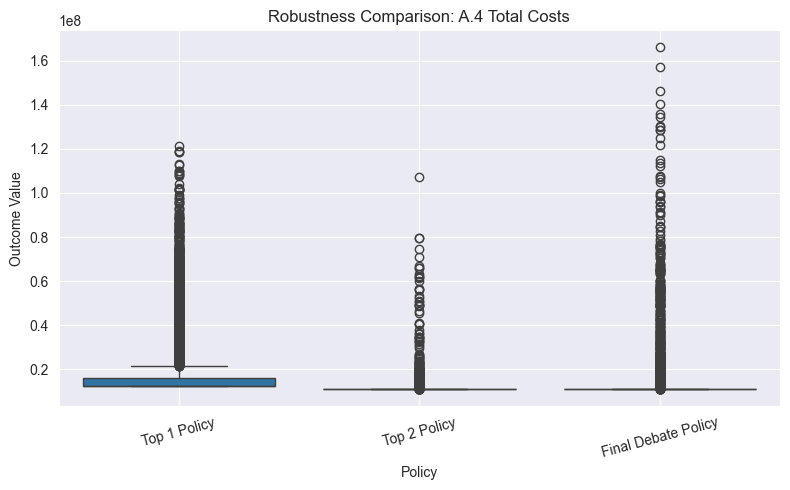

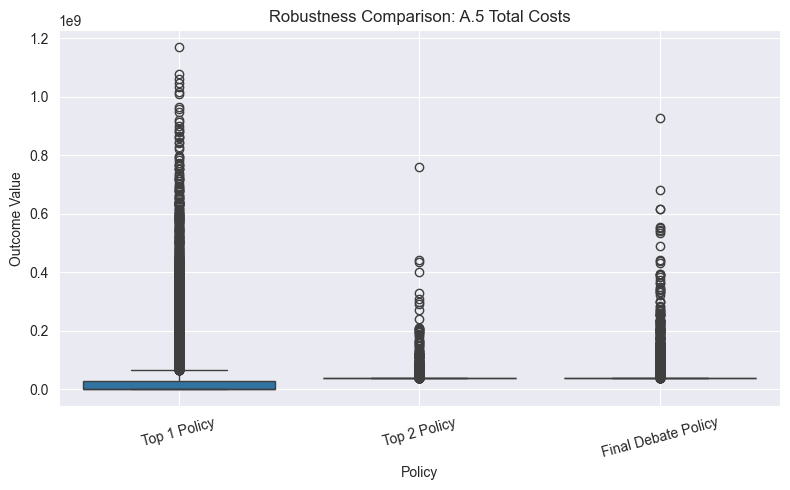

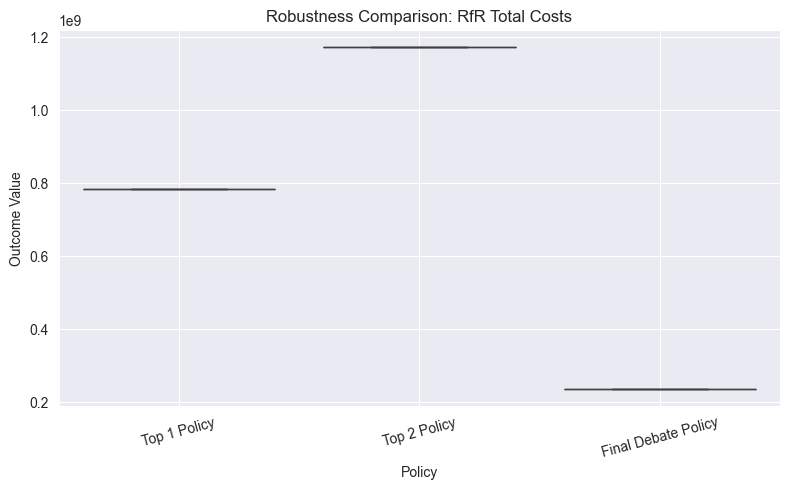

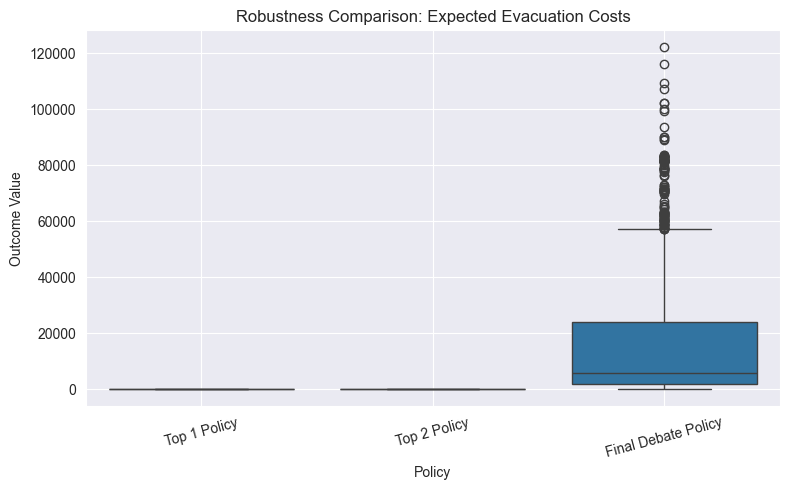

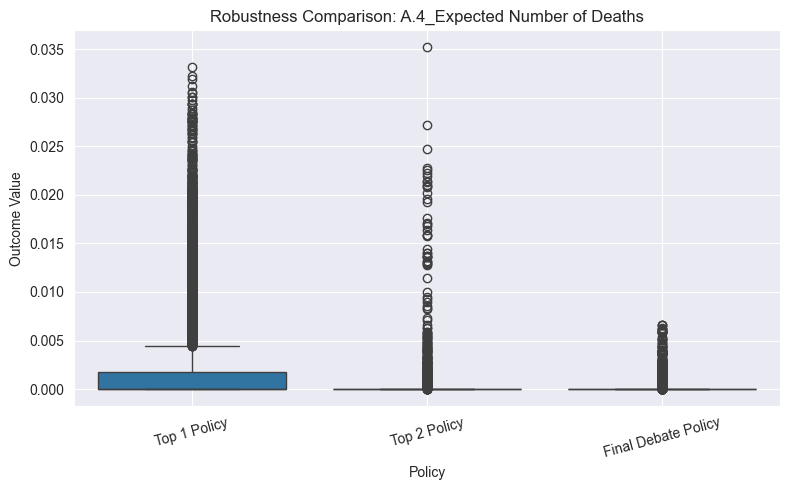

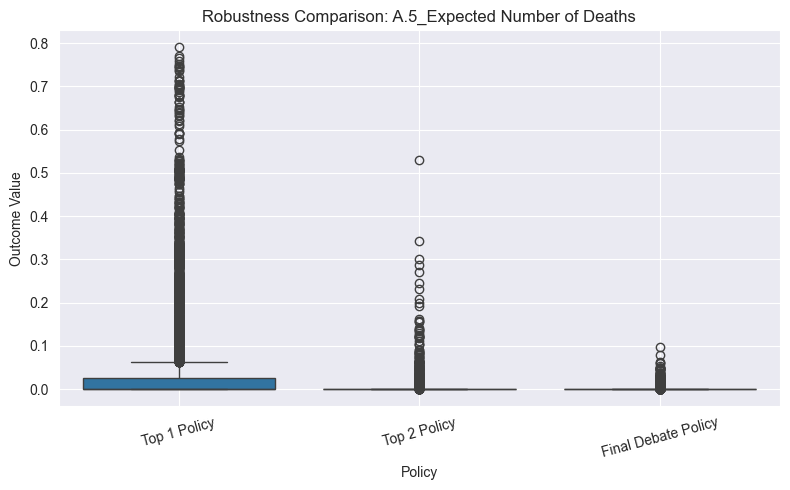

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define outcomes to visualize
selected_outcomes = [
    "A.4 Total Costs", "A.5 Total Costs", "RfR Total Costs",
    "Expected Evacuation Costs", "A.4_Expected Number of Deaths", "A.5_Expected Number of Deaths"
]

# Plotting
for outcome in selected_outcomes:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=combined_df, x="Policy", y=outcome)
    plt.title(f"Robustness Comparison: {outcome}")
    plt.ylabel("Outcome Value")
    plt.xlabel("Policy")
    plt.xticks(rotation=15)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Signal to Noise Ratio
The Higher SNR the better, this indicates the outcomes are consistent across scenarios of uncertainties

In [4]:
# === STEP 1: IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ema_workbench.em_framework.outcomes import ScalarOutcome

# === STEP 2: DEFINE SNR FUNCTION ===
def s_to_n(data, direction):
    """
    Computes signal-to-noise ratio.
    - If maximizing: mean / std
    - If minimizing: mean * std
    """
    mean = np.mean(data)
    std = np.std(data)
    if std == 0:
        std = 1
    return mean / std if direction == ScalarOutcome.MAXIMIZE else mean * std

# === STEP 3: DEFINE OUTCOMES AND DIRECTION ===
# Use your actual outcome names here
selected_outcomes = [
    "A.4 Total Costs", "A.5 Total Costs", "RfR Total Costs",
    "Expected Evacuation Costs", "A.4_Expected Number of Deaths", "A.5_Expected Number of Deaths"
]

# Assuming all outcomes are to be minimized (costs, deaths)
outcome_direction = ScalarOutcome.MINIMIZE

# === STEP 4: CALCULATE SNR SCORES FROM `results_dict` ===
# `results_dict` is assumed to be: { policy_label: DataFrame_of_outcomes }
snr_scores = {}

for policy_name, combined_df in results_dict.items():
    snr_dict = {}
    for outcome in selected_outcomes:
        values = combined_df[outcome]
        snr_dict[outcome] = s_to_n(values, outcome_direction)
    snr_scores[policy_name] = snr_dict

# Convert to DataFrame
df_snr = pd.DataFrame.from_dict(snr_scores).T
df_snr

,A.4 Total Costs,A.5 Total Costs,RfR Total Costs,Expected Evacuation Costs,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths
Top 1 Policy,2.453876e+14,4.606575e+15,7.853000e+08,0.000000e+00,1.226027e-05,0.003481
Top 2 Policy,3.319023e+13,5.519808e+14,1.172300e+09,0.000000e+00,1.387432e-07,0.000014
Final Debate Policy,1.014784e+14,1.213205e+15,2.365000e+08,2.172671e+08,3.253026e-08,0.000002


C:\Users\muham\AppData\Local\Temp\ipykernel_33704\218241267.py:61: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

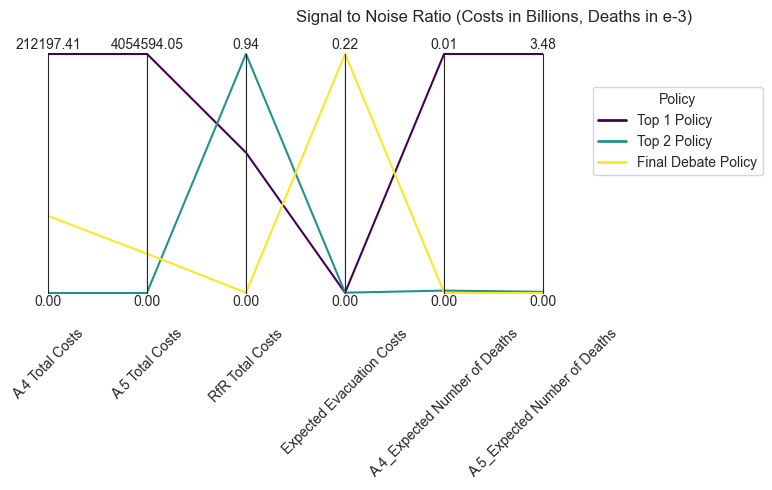

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from ema_workbench.analysis import parcoords

# --- Step 1. Load and Prepare the Data ---
df_raw = df_snr.copy()
cost_columns = [col for col in df_raw.columns if "Costs" in col]
death_columns = [col for col in df_raw.columns if "Deaths" in col]
df_raw[cost_columns] = df_raw[cost_columns] / 1e9
df_raw[death_columns] = df_raw[death_columns] * 1e3
# Reset the index so that policy names become a "Policy" column.
df = df_raw.reset_index().rename(columns={"index": "Policy"})
# All other columns are treated as outcome measures.
df_outcomes = df.drop("Policy", axis=1)

# --- Step 2. Compute Adjusted Data for Plotting ---
# For each outcome, subtract its minimum so that the best (lowest)
# value becomes 0 for plotting. (We keep the original values intact.)
df_outcomes_adj = df_outcomes.copy()
limits_dict = {}  # To hold axis limits for each outcome.
min_values = {}   # To store each column's original minimum.

for col in df_outcomes.columns:
    col_min = df_outcomes[col].min()
    col_max = df_outcomes[col].max()
    min_values[col] = col_min
    # Compute adjusted values: shifted_value = original_value - col_min.
    df_outcomes_adj[col] = df_outcomes[col] - col_min
    # The axis limits for this outcome: 0 (best) up to (col_max - col_min).
    limits_dict[col] = [0, col_max - col_min]

# Create the limits DataFrame as required by ParallelAxes.
limits_df = pd.DataFrame(limits_dict, index=["min", "max"])

# --- Step 3. Create the Parallel Coordinates Plot ---
plt.figure(figsize=(12, 8))
pa = parcoords.ParallelAxes(limits_df, fontsize=10, rot=45)

# Plot each policy's outcomes using the adjusted data.
# Also, create a proxy legend using Line2D objects.
legend_handles = []
legend_labels = []
num_rows = df_outcomes_adj.shape[0]

for i, (_, row) in enumerate(df_outcomes_adj.iterrows()):
    policy_label = df.iloc[i]["Policy"]
    color = plt.cm.viridis(i / (num_rows - 1) if num_rows > 1 else 0.5)
    # Plot without trying to capture a returned handle.
    pa.plot(row, label=policy_label, color=color)
    # Create a proxy object for the legend.
    legend_handles.append(Line2D([0], [0], color=color, lw=2))
    legend_labels.append(policy_label)

# Add a legend box that maps each color to its policy.
plt.legend(legend_handles, legend_labels, title="Policy",
           bbox_to_anchor=(1.5, 0.8), loc="upper left", borderaxespad=0)

plt.title("Signal to Noise Ratio (Costs in Billions, Deaths in e-3)")
plt.tight_layout()

# --- Step 4. Force Scientific Notation on Tick Labels ---
# For each axis, use a FuncFormatter that adds the original minimum back
# and formats the result in scientific notation.
for ax, col in zip(pa.axes, pa.axis_labels):
    formatter = FuncFormatter(lambda x, pos, col=col: f"{(x + min_values[col]):.2e}")
    ax.yaxis.set_major_formatter(formatter)
    # Hide any offset text.
    ax.get_yaxis().get_offset_text().set_visible(False)

# --- Step 5. Display the Plot ---
plt.show()

### Max Regret
Max regret tells us the worst-case deviation from the optimal in any scenario.

- Low value means: The policy never performs much worse than the best one, in any scenario. This is robust.
- High value means:	There is at least one scenario where this policy performs significantly worse than another. This policy is risky in edge cases.

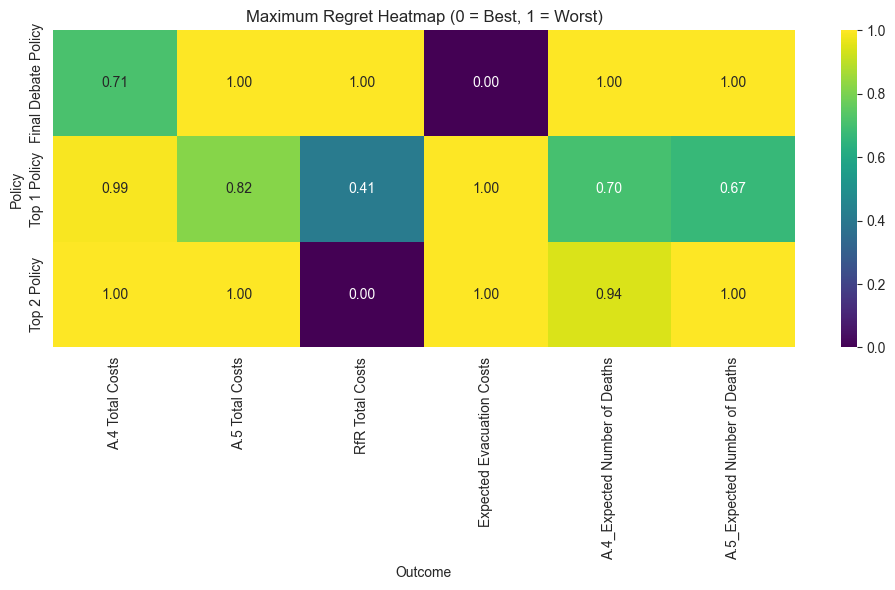

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Step 1: Rebuild a long-form DataFrame from results_dict with explicit scenario indexing ===
all_records = []
for label, df in results_dict.items():
    for scenario_id in range(len(df)):
        row = df.iloc[scenario_id].copy()
        row["Policy"] = label
        row["Scenario"] = scenario_id
        all_records.append(row)

long_df = pd.DataFrame(all_records)

# === Step 2: Calculate Max Regret ===
overall_regret = {}
max_regret = {}

for outcome in selected_outcomes:
    pivot = long_df.pivot(index="Scenario", columns="Policy", values=outcome)

    # Skip outcomes where all values are nan (avoid seaborn warning)
    if pivot.isnull().all().all():
        continue

    # Regret = max in each scenario - policy value
    regret_matrix = pivot.max(axis=1).values[:, np.newaxis] - pivot.values
    regret_df = pd.DataFrame(regret_matrix, columns=pivot.columns, index=pivot.index)

    overall_regret[outcome] = regret_df
    max_regret[outcome] = regret_df.max()

# === Step 3: Build DataFrame of max regret values ===
df_max_regret = pd.DataFrame(max_regret)

# === Step 4: Plot Heatmap ===
plt.figure(figsize=(10, 6))
sns.heatmap(df_max_regret_normalized, cmap="viridis", annot=True, fmt=".2f", cbar_kws={'label': None})
plt.title("Maximum Regret Heatmap (0 = Best, 1 = Worst)")
plt.ylabel("Policy")
plt.xlabel("Outcome")
plt.tight_layout()
plt.show()

### Scenario Discovery
Discover the worst scenario for every policies

- Here we try to find the worst scenario as the Expected Number of Deaths Higher than 1

In [65]:
import pandas as pd
from ema_workbench import load_results
import os

# === Load all policy results ===
base_dir = "../experimental data"
policy_files = {
    "Top 1 Policy": "pf_3_top1_policy_robustness.tar.gz",
    "Top 2 Policy": "pf_3_top2_policy_robustness.tar.gz",
    "Final Debate Policy": "pf_3_Final_Debate_policy_robustness.tar.gz"
}

# === Merge into one long-form DataFrame ===
all_records = []

for label, filename in policy_files.items():
    file_path = os.path.join(base_dir, filename)
    experiments, outcomes = load_results(file_path)
    df = pd.DataFrame(outcomes)
    df["Policy"] = label
    all_records.append(df)

combined_df = pd.concat(all_records, ignore_index=True)

# === Filter scenarios where deaths ≥ 1 in A.4 or A.5 ===
critical_scenarios = combined_df[
    (combined_df["A.4_Expected Number of Deaths"] >= 0.1) |
    (combined_df["A.5_Expected Number of Deaths"] >= 0.1)
]

# === Count by Policy, including zeros ===
all_policy_labels = combined_df["Policy"].unique()
count_by_policy = critical_scenarios["Policy"].value_counts().reindex(all_policy_labels, fill_value=0)

# === Print results ===
print("⚠️ Number of scenarios with Expected Deaths ≥ 1 in A.4 or A.5:")
print(count_by_policy)

⚠️ Number of scenarios with Expected Deaths ≥ 1 in A.4 or A.5:
Policy
Top 1 Policy           1164
Top 2 Policy             31
Final Debate Policy       0
Name: count, dtype: int64


We found that there is very minimum scenarios where the Expected Deaths higher than 0.1 for "Top 2 Policy" and "Final Debate Policy", So we will continue the scenario dsicovery only on "Top 1 Policy" where there are 1164 scenarios that matched

In [67]:
from ema_workbench.analysis import prim
from ema_workbench import load_results
import pandas as pd
import numpy as np
import os

# === Step 1: Load results from tar.gz files ===
base_dir = "../experimental data"
policy_files = {
    "Top 1 Policy": "pf_3_top1_policy_robustness.tar.gz"}

all_records = []
for label, filename in policy_files.items():
    file_path = os.path.join(base_dir, filename)
    experiments_1, outcomes_1 = load_results(file_path)

In [68]:
# === Step 2: Construct X
X = experiments_1.drop(columns=[
    "policy", "scenario"
])
# Drop levers from X
levers = [col for col in X.columns if "DikeIncrease" in col or "_RfR" in col or "EWS_DaysToThreat" in col]
X = X.drop(columns=levers)

# Target: deaths ≥ 0.0001 in either A.4 or A.5 (use tiny threshold if no ≥ 1 deaths found)
Y = ((outcomes_1["A.4_Expected Number of Deaths"] > 0.1) |
     (outcomes_1["A.5_Expected Number of Deaths"] > 0.1))

# === Step 3: Run PRIM ===
prim_alg = prim.Prim(X, Y, threshold=0.5)
box = prim_alg.find_box()
box.inspect_tradeoff()

alt.VConcatChart(...)

In [69]:
box.inspect(-1)

coverage      0.458763
density       0.996269
id           67.000000
k           534.000000
mass          0.053600
mean          0.996269
n           536.000000
res_dim       4.000000
Name: 67, dtype: float64

             box -1                                  
                min       max      qp value  qp value
A.5_pfail  0.000003  0.127957           NaN  0.000000
A.2_pfail  0.419743  0.999983  6.711666e-48       NaN
A.4_pfail  0.170618  0.999958  8.798061e-13       NaN
A.3_pfail  0.116808  0.977407  1.756293e-04  0.257807



[None]